# 4회차 - (유저 데이터 분석, 군집 분석)

- [1. 주문데이터 전처리](#1.-주문데이터-전처리)
    - [데이터 병합 및 탐색]
    - [데이터 전처리]
- [2. 유저향 주문데이터 분석](#2.-유저향-주문데이터-분석)
    - [유저 프로파일링]
    - [재주문 분석]
- [3. 유저향 시각화](#3.-유저향-시각화)
    - [거주 분포 시각화]
- [4. 프로파일 기반 군집분석](#4.-프로파일-기반-군집분석)
    - [유저 프로파일의 벡터 표현]
    - [다양한 관점으로 K-means 군집 분석 수행]
    - [t-sne 차원 축소 시각화]
- [5. 심화 예제](#5.-심화-예제)
    - [유저 행동 기반 장바구니 분석]

----

- 강의 순서
    - 각종 EDA 케이스를 통해, Data Preprocessing과 데이터를 탐색하는 법을 공부합니다.
    - 유저향 분석을 통해 프로파일링을 수행합니다.
    - 프로파일링 기반 군집 분석 활용방법을 알아봅니다.
    - 유저향 분석을 통해 수행할 수 있는 고급 분석 기법을 알아봅니다.
    
- 숙제
    - K-means, Word2Vec 알고리즘 공부해보기

In [1]:
pip install sklearn bokeh apriori apyori

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=ffabb1c517b80a2fbde8a1fc21053dfbcd9ea78f55aad9f75559e63210f45411
  Stored in directory: c:\users\min\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
  Created wheel for apriori: filename=apriori-1.0.0-py3-none-any.whl size=2477 sha256=fdb5491cf95ceb7dcfb0eb87375299e99331026f95325277f93c928fc310699d
  Stored in directory: c:\users\min\appdata\local\pip\cache\wheels\5b\68\dc\04db1838d64a3011a9b737e6f458894dc1f5cbadd128d54c1c
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5975 sha256=cd117a100137dbbcb04ed9b6e46318a414f9d6c89162c42bf1f92d97b4f66b36
  Stored in directory: c:\users\min\appdata\local\pip\cache\wheels\1b\02\6c\a45230be8603bd95c0a51cd2b289aefdd860c1a100eab73661
Successfully built sklearn apriori apyori
Note: you may need to restart the kernel to use updated packages.


In [2]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_dir = "../dataset/"

# 1. 주문데이터 전처리

### [데이터 병합 및 탐색]

----
#### *주문데이터 기준으로 데이터 병합*

In [10]:
order_df = pd.read_csv(data_dir + "olist_order_items_dataset.csv")
shipping_df = pd.read_csv(data_dir + "olist_orders_dataset.csv")
category_df = pd.read_csv(data_dir + "olist_products_dataset.csv")
user_df = pd.read_csv(data_dir + "olist_customers_dataset.csv")
location_df = pd.read_csv(data_dir + "olist_geolocation_dataset.csv")
product_category_name_translation_df = pd.read_csv(data_dir + "product_category_name_translation.csv")
payments_dataset = pd.read_csv(data_dir + "olist_order_payments_dataset.csv")

In [11]:
order_df['order_id'] = order_df['order_id'].astype(str)
shipping_df['order_id'] = shipping_df['order_id'].astype(str)
order_df = order_df.merge(shipping_df, how='left', on='order_id')

In [12]:
order_df['product_id'] = order_df['product_id'].astype(str)
category_df['product_id'] = category_df['product_id'].astype(str)
order_df = order_df.merge(category_df, how='left', on='product_id')

In [13]:
order_df['customer_id'] = order_df['customer_id'].astype(str)
user_df['customer_id'] = user_df['customer_id'].astype(str)
order_df = order_df.merge(user_df, how='left', on='customer_id')

In [14]:
order_df['customer_zip_code_prefix'] = order_df['customer_zip_code_prefix'].astype(str)
location_df['geolocation_zip_code_prefix'] = location_df['geolocation_zip_code_prefix'].astype(str)
location_df.columns = ['customer_zip_code_prefix', 'lat', 'lng', 'city', 'state']
location_df = location_df.groupby('customer_zip_code_prefix').agg({'lat': 'mean', 'lng': 'mean', 'city': 'first', 'state': 'first'}).reset_index()
order_df = order_df.merge(location_df, how='left', on='customer_zip_code_prefix')

In [15]:
order_df['product_category_name'] = order_df['product_category_name'].astype(str)
product_category_name_translation_df['product_category_name'] = product_category_name_translation_df['product_category_name'].astype(str)
order_df = order_df.merge(product_category_name_translation_df, how='left', on='product_category_name')

In [16]:
payments_dataset['order_id'] = payments_dataset['order_id'].astype(str)
order_df = order_df.merge(payments_dataset, how='left', on='order_id')

In [17]:
order_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,customer_state,lat,lng,city,state,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,RJ,-21.762775,-41.309633,campos dos goytacazes,RJ,cool_stuff,1.0,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,SP,-20.220527,-50.903424,santa fe do sul,SP,pet_shop,1.0,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,MG,-19.870305,-44.593326,pará de minas,MG,furniture_decor,1.0,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,SP,-23.089925,-46.611654,atibaia,SP,perfumery,1.0,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,SP,-23.243402,-46.827614,varzea paulista,SP,garden_tools,1.0,credit_card,3.0,218.04


In [18]:
order_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state', 'lat',
       'lng', 'city', 'state', 'product_category_name_english',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [19]:
anal_columns = ['order_id', 'product_id', 'customer_id', 'customer_unique_id',
                'order_item_id', 'price', 'freight_value', 
                'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date',
                'product_category_name_english',
                'customer_zip_code_prefix', 'lat', 'lng', 'city', 'state',
                'payment_type', 'payment_installments', 'payment_value'
                ]

In [20]:
order_df = order_df[anal_columns]

In [21]:
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,order_estimated_delivery_date,product_category_name_english,customer_zip_code_prefix,lat,lng,city,state,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,2017-09-29 00:00:00,cool_stuff,28013,-21.762775,-41.309633,campos dos goytacazes,RJ,credit_card,2.0,72.19
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,2017-05-15 00:00:00,pet_shop,15775,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,2018-02-05 00:00:00,furniture_decor,35661,-19.870305,-44.593326,pará de minas,MG,credit_card,5.0,216.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,2018-08-20 00:00:00,perfumery,12952,-23.089925,-46.611654,atibaia,SP,credit_card,2.0,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,2017-03-17 00:00:00,garden_tools,13226,-23.243402,-46.827614,varzea paulista,SP,credit_card,3.0,218.04


In [22]:
order_df.isnull().sum()

order_id                            0
product_id                          0
customer_id                         0
customer_unique_id                  0
order_item_id                       0
price                               0
freight_value                       0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_customer_date    2567
order_estimated_delivery_date       0
product_category_name_english    1723
customer_zip_code_prefix            0
lat                               312
lng                               312
city                              312
state                             312
payment_type                        3
payment_installments                3
payment_value                       3
dtype: int64

----
#### *결제 관련 피쳐 탐색*

In [23]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117604 non-null  object 
 1   product_id                     117604 non-null  object 
 2   customer_id                    117604 non-null  object 
 3   customer_unique_id             117604 non-null  object 
 4   order_item_id                  117604 non-null  int64  
 5   price                          117604 non-null  float64
 6   freight_value                  117604 non-null  float64
 7   order_status                   117604 non-null  object 
 8   order_purchase_timestamp       117604 non-null  object 
 9   order_approved_at              117589 non-null  object 
 10  order_delivered_customer_date  115037 non-null  object 
 11  order_estimated_delivery_date  117604 non-null  object 
 12  product_category_name_english 

<AxesSubplot:>

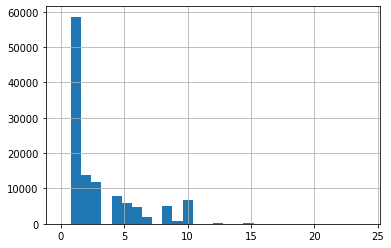

In [38]:
plt.ticklabel_format(style='plain')
order_df['payment_installments'].hist(bins = 30)

<AxesSubplot:>

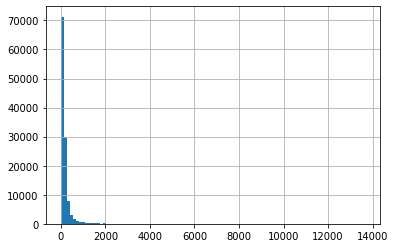

In [42]:
plt.ticklabel_format(style='plain')
order_df['payment_value'].hist(bins=100)

In [43]:
order_df['payment_type'].value_counts()

credit_card    86769
boleto         22867
voucher         6274
debit_card      1691
Name: payment_type, dtype: int64

<AxesSubplot:>

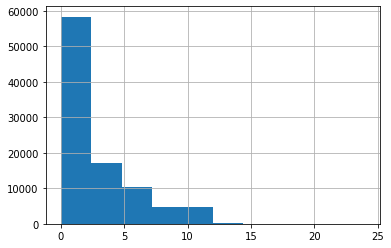

In [45]:
#유저별로 할인을 얼마나 받는지 파악하기
order_df.groupby('customer_unique_id')["payment_installments"].mean().hist()

- credit_card : 신용카드
- boleto : 현금 결제 (지정된 장소로 가서 납부하는 브라질 고유의 현금결제 수단이라고 함)
- voucher : 충전식 선불결제
- debit_card : 직불카드

----
#### *데이터 전처리*

In [46]:
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])
order_df['order_approved_at'] = pd.to_datetime(order_df['order_approved_at'])
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'])
order_df['order_estimated_delivery_date'] = pd.to_datetime(order_df['order_estimated_delivery_date'])

In [47]:
order_df = order_df[order_df['order_status']=='delivered']
order_df = order_df.dropna()

----
# 2. 유저향 주문데이터 분석
### [유저 프로파일링]


여기부터 정리 ㄱㄱ

----
#### *유저별 주문 횟수*

In [49]:
order_df['customer_unique_id'].nunique()

91809

In [50]:
order_df.groupby('customer_unique_id')['order_id'].nunique()
#nunique 공통되는걸 1개로 해버리는 것이다.

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 91809, dtype: int64

<AxesSubplot:>

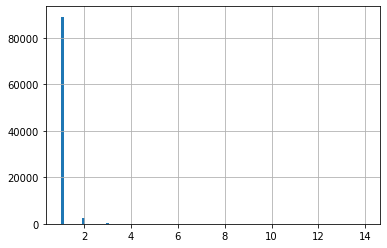

In [52]:
order_df.groupby('customer_unique_id')['order_id'].nunique().hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x2dcf3550640>,
 'caps': [<matplotlib.lines.Line2D at 0x2dcf3550ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2dcf35501f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2dcf3545400>],
 'fliers': [<matplotlib.lines.Line2D at 0x2dcf3545790>],
 'means': []}

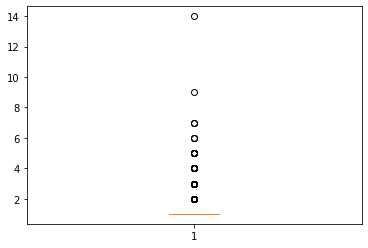

In [53]:
plt.boxplot(order_df.groupby('customer_unique_id')['order_id'].nunique())

In [54]:
order_df.groupby('customer_unique_id')['order_id'].nunique().describe()

count    91809.000000
mean         1.033080
std          0.206859
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: order_id, dtype: float64

In [70]:
user_df = order_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
user_df.head()
#사용자 마다 (customer_unique_id마다) 몇 번 주문을 했는지를 데이터 프레임으로 표현해 보세요  (몇번이라 함은 unique한 order_id)
#groupby한 다음 .reset_index() 해줘야 데이터 프레임으로 묶인다.

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [71]:
user_df[user_df['order_id']>1].shape

(2732, 2)

In [72]:
user_df[user_df['order_id']>2].shape

(220, 2)

----
#### *유저별 주문 갯수*

In [73]:
order_df.groupby('customer_unique_id')['order_id'].count()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 91809, dtype: int64

<AxesSubplot:>

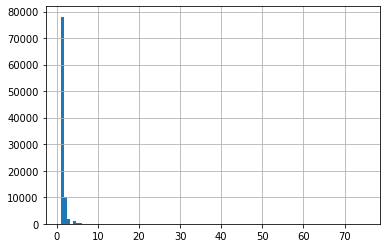

In [74]:
order_df.groupby('customer_unique_id')['order_id'].count().hist(bins=100)

In [75]:
user_df = order_df.groupby('customer_unique_id')['order_id'].count().reset_index()
user_df.head()

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [76]:
user_df[user_df['order_id']>1].shape

(13768, 2)

In [77]:
user_df[user_df['order_id']>2].shape

(3534, 2)

----
#### *유저별 주문 카테고리 갯수*

In [87]:
order_df.columns

Index(['order_id', 'product_id', 'customer_id', 'customer_unique_id',
       'order_item_id', 'price', 'freight_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'product_category_name_english', 'customer_zip_code_prefix', 'lat',
       'lng', 'city', 'state', 'payment_type', 'payment_installments',
       'payment_value', 'order_purchase_date'],
      dtype='object')

In [91]:
user_df = order_df.groupby('customer_unique_id')['product_category_name_english'].nunique().reset_index()

In [92]:
user_df.head()

,customer_unique_id,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [93]:
user_df['product_category_name_english'].describe()

count    91809.000000
mean         1.024998
std          0.167300
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: product_category_name_english, dtype: float64

In [94]:
user_df[user_df['product_category_name_english']>1].shape

(2154, 2)

----
#### *유저별 주문 주기*

두 번 이상 주문항 사람들을 대상으로 한다
주문한 날짜들 간의 차이가 어느 정도 나오는지를 분석 해보자 

1. 날짜 데이터를 가지고 있는 칼럼이 뭔지 찾아본다
2. 날짜 데이터를 가지고 있는 칼럼을 groupby해서 리스트로 뽑아낸다
3. 날짜 데이터의 타입을 보고 주기는 일 단위 이므로 .dt.date를 이용해 날짜 타입으로 바꾼다.
4. 날짜간의 연산을 통해 주기를 알아내면 되는데 이제 여기에 2번 이상 주문한 사람들에 대한 정보도 추가해 준다음 연산을 해줘야 한다.

In [ ]:
#유저별 "주문 날짜를 리스트로 하는 column"을 포함한 데이터 프레임을 만들어보자

In [99]:
order_df['order_purchase_date'] = order_df['order_purchase_timestamp'].dt.date

In [100]:
user_df = order_df.groupby('customer_unique_id')['order_purchase_date'].nunique().reset_index()
user_df.shape

(91809, 2)

In [101]:
user_df = user_df[user_df['order_purchase_date']>1]
user_df.head()

,customer_unique_id,order_purchase_date
103,004288347e5e88a27ded2bb23747066c,2
399,011575986092c30523ecb71ff10cb473,2
414,011b4adcd54683b480c4d841250a987f,2
423,012452d40dafae4df401bced74cdb490,2
432,012a218df8995d3ec3bb221828360c86,2


In [102]:
user_df.shape

(1966, 2)

In [127]:
#이제 2개 이상 구매한 사람들의 user_id를 .tolist를 이용해서 찾아내기 
cuid_list = user_df['customer_unique_id'].tolist()

#isin(  )의 ()안의 값에 데이터 프레임의 특정값이 포함 되어 있는 것들을 가지고 오는 코드
temp_df = order_df[order_df['customer_unique_id'].isin(cuid_list)]

In [128]:
temp_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,product_category_name_english,customer_zip_code_prefix,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,pet_shop,15775,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26
40,0017afd5076e074a48f1f1a4c7bac9c5,fe59a1e006df3ac42bf0ceb876d70969,8085a9af46f619bc25966f151a362b0d,98758d88bf4b8eef1372ddee45d63178,1,809.10,44.29,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,...,computers_accessories,57250,-9.784323,-36.349941,campo alegre,AL,credit_card,10.0,853.39,2017-04-06
56,0020a222f55eb79a372d0efee3cca688,e19ddcc85537b41f22116c8d5425ef46,0c45155afd8ff99622c40824057f9b34,87ae4c644c15d9c6b6f826dfec33b340,1,29.99,15.10,delivered,2017-08-15 02:45:18,2017-08-15 03:03:44,...,furniture_decor,27273,-22.518974,-44.136149,volta redonda,RJ,credit_card,4.0,45.09,2017-08-15
153,005d9a5423d47281ac463a968b3936fb,fb7a100ec8c7b34f60cec22b1a9a10e0,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,1,49.99,18.12,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,toys,13720,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18
154,005d9a5423d47281ac463a968b3936fb,4c3ae5db49258df0784827bdacf3b396,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,2,24.99,13.58,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,baby,13720,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18


In [129]:
def get_dayterm_by_orderdate(x):
    prev_purchase_date = None
    dayterm_list = []
    for purchase_date in x.sort_values('order_purchase_date')['order_purchase_date'].tolist():
        if prev_purchase_date is not None:
            dayterm_list.append((purchase_date - prev_purchase_date).days)
        prev_purchase_date = purchase_date
    return dayterm_list

temp_df.groupby('customer_unique_id').apply(lambda x: get_dayterm_by_orderdate(x))

customer_unique_id
004288347e5e88a27ded2bb23747066c               [171]
011575986092c30523ecb71ff10cb473                [60]
011b4adcd54683b480c4d841250a987f            [177, 0]
012452d40dafae4df401bced74cdb490            [330, 0]
012a218df8995d3ec3bb221828360c86             [0, 42]
                                          ...       
fe81bb32c243a86b2f86fbf053fe6140    [9, 115, 111, 7]
fed519569d16e690df6f89cb99d4e682                [88]
ff03923ad1eb9e32304deb7f9b2a45c9                [33]
ff8892f7c26aa0446da53d01b18df463               [186]
ff922bdd6bafcdf99cb90d7f39cea5b3           [182, 22]
Length: 1966, dtype: object

In [131]:
temp_df = temp_df.groupby('customer_unique_id').apply(lambda x: get_dayterm_by_orderdate(x)).reset_index()
temp_df.head()

,customer_unique_id,0
0,004288347e5e88a27ded2bb23747066c,[171]
1,011575986092c30523ecb71ff10cb473,[60]
2,011b4adcd54683b480c4d841250a987f,"[177, 0]"
3,012452d40dafae4df401bced74cdb490,"[330, 0]"
4,012a218df8995d3ec3bb221828360c86,"[0, 42]"


In [124]:
temp_df['dayterm_mean'] = temp_df[0].apply(lambda x: np.mean(x))

In [796]:
temp_df.head()

,customer_unique_id,0,dayterm_mean
0,02e9109b7e0a985108b43e573b6afb23,"[171, 0, 0, 1]",43.000000
1,041caba6a63ace5818387698ea85cdb2,"[247, 188]",217.500000
2,07b1b60bca2b6326fa2adb259ea4a55f,"[0, 4, 40]",14.666667
3,083ca1aa470c280236380973a48f77c6,"[8, 11]",9.500000
4,08c07c761592a71b85136aa4fe76a6f4,"[168, 70]",119.000000


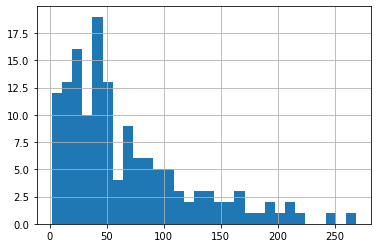

In [797]:
temp_df['dayterm_mean'].hist(bins=30)

----
#### *유저별 선호 가격대 (카테고리 기반)*

In [798]:
order_df.shape

(113069, 22)

In [799]:
# 거래 가격(price)의 z-score를 계산합니다. 이는 해당 데이터의 가격이 카테고리의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
order_df['z_score_in_category'] = order_df.groupby('product_category_name_english')['price'].transform(lambda x: (x - x.mean()) / x.std())

In [800]:
def q02(x):
    return x.quantile(0.2)

def q80(x):
    return x.quantile(0.8)

category_price_df = order_df.groupby('product_category_name_english').agg({'z_score_in_category': [q02, q80]})
category_price_df.head()

z_score_in_category          
                                              q02       q80
product_category_name_english                              
agro_industry_and_commerce              -0.752557  0.244556
air_conditioning                        -0.661315  0.224604
art                                     -0.151633 -0.012965
arts_and_craftmanship                   -0.770073  0.728484
audio                                   -0.747253  0.327674

In [801]:
category_price_dict = category_price_df.to_dict()

In [802]:
category_price_dict

{('z_score_in_category',
  'q02'): {'agro_industry_and_commerce': -0.7525568025386538, 'air_conditioning': -0.6613154981840297, 'art': -0.1516327762341563, 'arts_and_craftmanship': -0.770073413065056, 'audio': -0.747252648800402, 'auto': -0.5143975739449504, 'baby': -0.4275621501298089, 'bed_bath_table': -0.6488736662186889, 'books_general_interest': -0.5417698880544167, 'books_imported': -0.5625050068920596, 'books_technical': -0.696499303745205, 'cds_dvds_musicals': -0.7182430061427791, 'christmas_supplies': -0.8522568212195514, 'cine_photo': -0.6085667964561602, 'computers': -0.7412689492150075, 'computers_accessories': -0.47925595416968253, 'consoles_games': -0.48621208329327087, 'construction_tools_construction': -0.454159281039107, 'construction_tools_lights': -0.6825141527255499, 'construction_tools_safety': -0.5150671630048432, 'cool_stuff': -0.5689961003531501, 'costruction_tools_garden': -0.5250430124975763, 'costruction_tools_tools': -0.4698912559040984, 'diapers_and_hygiene

In [803]:
def get_price_level(z_score, category):
    lower_bound = category_price_dict[('z_score_in_category', 'q02')][category]
    upper_bound = category_price_dict[('z_score_in_category', 'q80')][category]
    if z_score < lower_bound:
        return 0
    else:
        if z_score > upper_bound:
            return 2
        else:
            return 1

In [804]:
order_df['price_level'] = order_df.apply(lambda x: get_price_level(x['z_score_in_category'], x['product_category_name_english']), axis=1)

In [805]:
order_df['price_level'].head()

0    1
1    2
2    2
3    0
4    2
Name: price_level, dtype: int64

In [806]:
order_df.groupby('customer_unique_id')['price_level'].mean()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    2.0
0000b849f77a49e4a4ce2b2a4ca5be3f    0.0
0000f46a3911fa3c0805444483337064    1.0
0000f6ccb0745a6a4b88665a16c9f078    1.0
0004aac84e0df4da2b147fca70cf8255    2.0
                                   ... 
fffcf5a5ff07b0908bd4e2dbc735a684    2.0
fffea47cd6d3cc0a88bd621562a9d061    1.0
ffff371b4d645b6ecea244b27531430a    1.0
ffff5962728ec6157033ef9805bacc48    1.0
ffffd2657e2aad2907e67c3e9daecbeb    1.0
Name: price_level, Length: 91809, dtype: float64

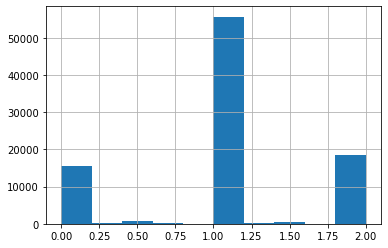

In [807]:
order_df.groupby('customer_unique_id')['price_level'].mean().hist()

----
#### *유저별 결제 정보*
- 결제 총액
- 선호 결제방법
- 평균 할부개월

In [808]:
order_df.columns

Index(['order_id', 'product_id', 'customer_id', 'customer_unique_id',
       'order_item_id', 'price', 'freight_value', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'product_category_name_english', 'customer_zip_code_prefix', 'lat',
       'lng', 'city', 'state', 'payment_type', 'payment_installments',
       'payment_value', 'order_purchase_date', 'z_score_in_category',
       'price_level'],
      dtype='object')

In [135]:
order_df.groupby('customer_unique_id')['payment_value'].sum()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2     141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      27.19
0000f46a3911fa3c0805444483337064      86.22
0000f6ccb0745a6a4b88665a16c9f078      43.62
0004aac84e0df4da2b147fca70cf8255     196.89
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    4134.84
fffea47cd6d3cc0a88bd621562a9d061      84.58
ffff371b4d645b6ecea244b27531430a     112.46
ffff5962728ec6157033ef9805bacc48     133.69
ffffd2657e2aad2907e67c3e9daecbeb      71.56
Name: payment_value, Length: 91809, dtype: float64

<AxesSubplot:>

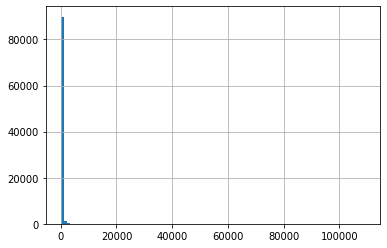

In [138]:
order_df.groupby('customer_unique_id')['payment_value'].sum().hist(bins=100)

In [141]:
order_df.groupby('customer_unique_id')['payment_value'].sum().describe()

count     91809.000000
mean        212.134840
std         644.361571
min           9.590000
25%          63.830000
50%         112.830000
75%         202.140000
max      109312.640000
Name: payment_value, dtype: float64

<AxesSubplot:>

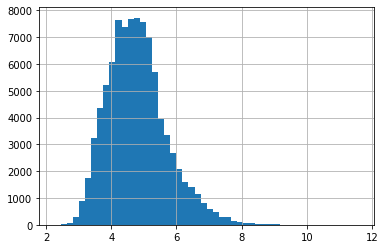

In [142]:
np.log(order_df.groupby('customer_unique_id')['payment_value'].sum()).hist(bins=50)

In [143]:
order_df.groupby('customer_unique_id')['payment_installments'].mean().describe()

count    91809.000000
mean         2.905209
std          2.682239
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         24.000000
Name: payment_installments, dtype: float64

<AxesSubplot:>

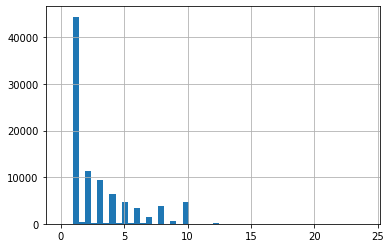

In [144]:
order_df.groupby('customer_unique_id')['payment_installments'].mean().hist(bins=50)

<AxesSubplot:>

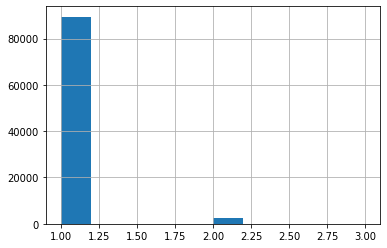

In [145]:
order_df.groupby('customer_unique_id')['payment_type'].nunique().hist()

In [146]:
order_df.groupby('customer_unique_id')['payment_type'].nunique().value_counts()

1    89426
2     2371
3       12
Name: payment_type, dtype: int64

In [817]:
order_df.groupby('payment_type')['customer_unique_id'].nunique()

payment_type
boleto         18407
credit_card    70834
debit_card      1439
voucher         3524
Name: customer_unique_id, dtype: int64

----
### [재주문 분석]
- 2회 이상 무언가를 구매한 유저 대상

In [818]:
user_df = order_df.groupby('customer_unique_id')['order_purchase_date'].nunique().reset_index()
user_df = user_df[user_df['order_purchase_date']>1]
user_df.head()

,customer_unique_id,order_purchase_date
103,004288347e5e88a27ded2bb23747066c,2
399,011575986092c30523ecb71ff10cb473,2
414,011b4adcd54683b480c4d841250a987f,2
423,012452d40dafae4df401bced74cdb490,2
432,012a218df8995d3ec3bb221828360c86,2


In [819]:
cuid_list = user_df['customer_unique_id'].tolist()
temp_df = order_df[order_df['customer_unique_id'].isin(cuid_list)]
temp_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,lat,lng,city,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category,price_level
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,-20.220527,-50.903424,santa fe do sul,SP,credit_card,3.0,259.83,2017-04-26,0.915267,2
40,0017afd5076e074a48f1f1a4c7bac9c5,fe59a1e006df3ac42bf0ceb876d70969,8085a9af46f619bc25966f151a362b0d,98758d88bf4b8eef1372ddee45d63178,1,809.10,44.29,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,...,-9.784323,-36.349941,campo alegre,AL,credit_card,10.0,853.39,2017-04-06,4.038650,2
56,0020a222f55eb79a372d0efee3cca688,e19ddcc85537b41f22116c8d5425ef46,0c45155afd8ff99622c40824057f9b34,87ae4c644c15d9c6b6f826dfec33b340,1,29.99,15.10,delivered,2017-08-15 02:45:18,2017-08-15 03:03:44,...,-22.518974,-44.136149,volta redonda,RJ,credit_card,4.0,45.09,2017-08-15,-0.643747,0
153,005d9a5423d47281ac463a968b3936fb,fb7a100ec8c7b34f60cec22b1a9a10e0,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,1,49.99,18.12,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18,-0.508681,1
154,005d9a5423d47281ac463a968b3936fb,4c3ae5db49258df0784827bdacf3b396,a2be07c22a9d2071f65b6770e47f540b,6204c4e582a95b6a350adf6988623bfb,2,24.99,13.58,delivered,2017-10-18 12:14:29,2017-10-18 12:28:16,...,-21.582987,-46.947759,são josé do rio pardo,SP,credit_card,10.0,145.26,2017-10-18,-0.494177,0


In [820]:
#2회 이상 구매한 유저들 중에서 같은 제품만을 구매한 사람이 있는지를 파악하는 것
temp_df.groupby('customer_unique_id')['product_id'].value_counts()

customer_unique_id                product_id                      
004288347e5e88a27ded2bb23747066c  6e1b14d3cbb5fb3a2c00351007127dfd    1
                                  a2bd2eae20998a24c22b110334928b02    1
011575986092c30523ecb71ff10cb473  098c663630a7a81f7d7f42a2ce0b02d7    1
                                  818430a64bb4e935b35f1f4da32612eb    1
011b4adcd54683b480c4d841250a987f  ed2067a9c1f79553088a3c67b99a9f97    2
                                                                     ..
ff8892f7c26aa0446da53d01b18df463  09690382191f134e947200ccfe32f7c0    1
                                  cfb763496d9fc48751a27db4fd02aa2d    1
ff922bdd6bafcdf99cb90d7f39cea5b3  b8762d562d810c2f8d7ad7e9c12957be    1
                                  e54cb69cc7bf5d21921991aae48501fb    1
                                  fd3a4121e687a6b84e7af92606d5d718    1
Name: product_id, Length: 4173, dtype: int64

In [ ]:
#zip은 두 리스트의 원소들을 순서대로 쌍을 지을 때 쓰는 함수이다.

In [821]:
# temp_df['reorder_product_cnt']
def test(x):
    product_order_counts = x.value_counts()
    reorder_products = product_order_counts[product_order_counts>1]
    reorder_list = []
    for product_id, reorder_cnt in zip(reorder_products.index.tolist(), reorder_products.values.tolist()):
        reorder_list.append((product_id, reorder_cnt-1))
    return reorder_list

temp_df.groupby('customer_unique_id')['product_id'].apply(lambda x: test(x))

customer_unique_id
004288347e5e88a27ded2bb23747066c                                         []
011575986092c30523ecb71ff10cb473                                         []
011b4adcd54683b480c4d841250a987f    [(ed2067a9c1f79553088a3c67b99a9f97, 1)]
012452d40dafae4df401bced74cdb490    [(bb50f2e236e5eea0100680137654686c, 1)]
012a218df8995d3ec3bb221828360c86    [(e64fc38d9e0040126742405519bdea19, 1)]
                                                     ...                   
fe81bb32c243a86b2f86fbf053fe6140    [(e2bb00220a167d9e60b6776ac33717bc, 1)]
fed519569d16e690df6f89cb99d4e682                                         []
ff03923ad1eb9e32304deb7f9b2a45c9    [(6463e442310f2f4f321c83a32d8c662b, 1)]
ff8892f7c26aa0446da53d01b18df463                                         []
ff922bdd6bafcdf99cb90d7f39cea5b3                                         []
Name: product_id, Length: 1966, dtype: object

In [822]:
reorder_info_df = temp_df.groupby('customer_unique_id')['product_id'].apply(lambda x: test(x)).reset_index()
reorder_info_df.head()

,customer_unique_id,product_id
0,004288347e5e88a27ded2bb23747066c,[]
1,011575986092c30523ecb71ff10cb473,[]
2,011b4adcd54683b480c4d841250a987f,"[(ed2067a9c1f79553088a3c67b99a9f97, 1)]"
3,012452d40dafae4df401bced74cdb490,"[(bb50f2e236e5eea0100680137654686c, 1)]"
4,012a218df8995d3ec3bb221828360c86,"[(e64fc38d9e0040126742405519bdea19, 1)]"


In [823]:
reorder_info_df = reorder_info_df[reorder_info_df['product_id'].apply(lambda x: len(x)) > 0]
reorder_info_df.shape

(672, 2)

In [824]:
reorder_info_df.head()

,customer_unique_id,product_id
2,011b4adcd54683b480c4d841250a987f,"[(ed2067a9c1f79553088a3c67b99a9f97, 1)]"
3,012452d40dafae4df401bced74cdb490,"[(bb50f2e236e5eea0100680137654686c, 1)]"
4,012a218df8995d3ec3bb221828360c86,"[(e64fc38d9e0040126742405519bdea19, 1)]"
6,013f4353d26bb05dc6652f1269458d8d,"[(9e164b4afdecc7c67fb9b6f12c104e21, 1)]"
8,0178b244a5c281fb2ade54038dd4b161,"[(32dfa38395ccd47d7b320470b0514fee, 1)]"


----
#### *유저별 재주문 횟수*

In [825]:
reorder_info_df['reorder_total_count'] = reorder_info_df['product_id'].apply(lambda x: sum([tup[1] for tup in x]))

In [826]:
reorder_info_df.head()

,customer_unique_id,product_id,reorder_total_count
2,011b4adcd54683b480c4d841250a987f,"[(ed2067a9c1f79553088a3c67b99a9f97, 1)]",1
3,012452d40dafae4df401bced74cdb490,"[(bb50f2e236e5eea0100680137654686c, 1)]",1
4,012a218df8995d3ec3bb221828360c86,"[(e64fc38d9e0040126742405519bdea19, 1)]",1
6,013f4353d26bb05dc6652f1269458d8d,"[(9e164b4afdecc7c67fb9b6f12c104e21, 1)]",1
8,0178b244a5c281fb2ade54038dd4b161,"[(32dfa38395ccd47d7b320470b0514fee, 1)]",1


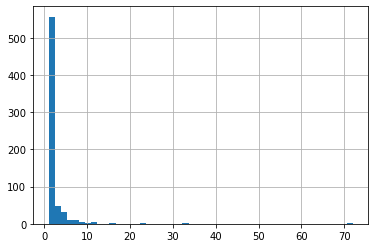

In [827]:
reorder_info_df['reorder_total_count'].hist(bins=50)

----
#### *재주문 많은 상품&카테고리*

In [828]:
product_reorder_dict = {}

for index, row in reorder_info_df.iterrows():
    for tup in row['product_id']:
        product_id, reorder_cnt = tup[0], tup[1]
        if product_id in product_reorder_dict:
            product_reorder_dict[product_id] += reorder_cnt
        else:
            product_reorder_dict[product_id] = reorder_cnt

In [829]:
# product_reorder_dict

In [830]:
sorted_dict = sorted(product_reorder_dict.items(), key = lambda item: item[1], reverse = True)
sorted_dict[:10]

[('ebf9bc6cd600eadd681384e3116fda85', 41),
 ('e7cc48a9daff5436f63d3aad9426f28b', 23),
 ('0449db5eede617c5fd413071d582f038', 23),
 ('5ddab10d5e0a23acb99acf56b62b3276', 20),
 ('89b190a046022486c635022524a974a8', 14),
 ('812f428f6757ab16c46cffc68f2e90c5', 12),
 ('04c4a4b9c924494fcf82e0fba966f955', 11),
 ('928e52a9ad53a294fdcc91bcf59d1751', 11),
 ('f3720bc68555b1bff49b9ffd41b017ac', 11),
 ('4eb99b5f0d7e411f246a5c9c0ae27a5e', 11)]

In [831]:
category_df = pd.read_csv(data_dir + "olist_products_dataset.csv")

In [832]:
product_category_dict = order_df[['product_id', 'product_category_name_english']].set_index('product_id').to_dict()

In [833]:
# product_category_dict['product_category_name_english']

In [834]:
for tup in sorted_dict[:10]:
    print(product_category_dict['product_category_name_english'][tup[0]])

bed_bath_table
telephony
garden_tools
housewares
furniture_decor
furniture_decor
watches_gifts
housewares
computers_accessories
furniture_decor


----
# 3. 유저향 시각화
### [거주 분포 시각화]

----
#### *시각화 할 데이터 전처리*

In [835]:
user_df = pd.read_csv(data_dir + "olist_customers_dataset.csv")
location_df = pd.read_csv(data_dir + "olist_geolocation_dataset.csv")

In [836]:
user_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [837]:
location_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [838]:
user_df['customer_zip_code_prefix'] = user_df['customer_zip_code_prefix'].astype(str)
location_df['geolocation_zip_code_prefix'] = location_df['geolocation_zip_code_prefix'].astype(str)
location_df.columns = ['customer_zip_code_prefix', 'lat', 'lng', 'city', 'state']
location_df = location_df.groupby('customer_zip_code_prefix').agg({'lat': 'mean', 'lng': 'mean', 'city': 'first', 'state': 'first'}).reset_index()
user_df = user_df.merge(location_df, how='left', on='customer_zip_code_prefix')

In [839]:
user_df = user_df.dropna()
user_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,lat,lng,city,state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,campinas,SP


----
#### *Bokeh 시각화*

In [840]:
# pip install bokeh
# https://docs.bokeh.org/en/latest/

from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

In [841]:
# Web Mercator 데이터 포맷으로 변환
def wgs84_to_web_mercator(df, lng, lat):
    k = 6378137
    df["x"] = df[lng] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

order_df = wgs84_to_web_mercator(order_df, 'lng', 'lat')

In [842]:
city_df = user_df.groupby('city').agg({'customer_id' : ['count'], 'lat' : ['mean'], 'lng' : ['mean']})
city_df = city_df.reset_index()

In [843]:
city_df.columns = city_df.columns.to_flat_index()
city_df.columns = ['city', 'count', 'lat', 'lng']

In [844]:
city_df = wgs84_to_web_mercator(city_df, 'lng', 'lat')
city_df.head()

,city,count,lat,lng,x,y
0,abadia dos dourados,3,-18.474476,-47.407837,-5.277416e+06,-2.093161e+06
1,abadiania,1,-16.193742,-48.709521,-5.422319e+06,-1.827170e+06
2,abaete,12,-19.158206,-45.446300,-5.059059e+06,-2.173571e+06
3,abaetetuba,11,-1.723024,-48.881065,-5.441415e+06,-1.918351e+05
4,abaiara,2,-7.358247,-39.045817,-4.346560e+06,-8.213773e+05


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9088465580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9088465c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9088465220>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8ac5d21340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8ac5d21640>],
 'means': []}

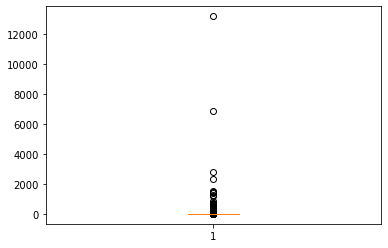

In [845]:
plt.boxplot(city_df['count'])

In [846]:
city_df['count'] = city_df['count'].apply(lambda x: np.log(x))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8aa622d7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8aa622de80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8aa622d430>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8aa6211550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8aa6211820>],
 'means': []}

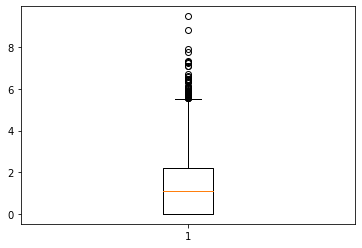

In [847]:
plt.boxplot(city_df['count'])

In [848]:
# 맵의 확대 정도 지정
zoom_scale = 3000
x = order_df['x']
y = order_df['y']

# 지도에서 표시할 x,y의 범위 지정
x_min = int(x.mean() - (zoom_scale * 350))
x_max = int(x.mean() + (zoom_scale * 350))
y_min = int(y.mean() - (zoom_scale * 350))
y_max = int(y.mean() + (zoom_scale * 350))

# 사용할 지도의 스타일 정의 : OSM, ESRI, google Type...
tile_provider = get_provider(OSM)

# Bokh 플롯 객체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = True

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [849]:
def bubble_map(plot, df, count_col, leg_label, lon, lat, scale):
    # color palete 지정
    mapper = LinearColorMapper(
        palette='Greys256',
        low=df[count_col].max(),
        high=df[count_col].min()
    )

    # 지도에 circle 포인트 그리기
    c = plot.circle(x='x',
                    y='y',
                    color=transform(count_col, mapper),
                    size=7,
                    alpha=0.4,
                    source=df,
                    legend_label=leg_label)
    
    # mouse hover에 표기할 정보
    tip_label='@'+count_col
    lat_label='@'+lat
    lon_label='@'+lon
    circle_hover = HoverTool(tooltips=[(count_col, tip_label), ('Lat:', lat_label), ('Lon:', lon_label)], 
                             mode='mouse', 
                             point_policy='follow_mouse', 
                             renderers=[c])
    circle_hover.renderers.append(c)
    
    # mouse hover와 legend 정보 부착
    plot.tools.append(circle_hover)
    plot.legend.location = "top_right"
    plot.legend.click_policy="hide"
    
    # color bar 정보 부착
    color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 12,
                     location = (0,0),
                     title = 'order count')
    plot.add_layout(color_bar, 'right')

In [850]:
# Create bubble map
bubble_map(plot=plot,
           df=city_df,
           count_col='count', 
           leg_label='Order Count Map',
           lon='lng',
           lat='lat',
           scale=zoom_scale)

In [851]:
show(plot)

----
# 4. 프로파일 기반 군집분석
### [유저 프로파일의 벡터 표현]

----
#### *features from user profile EDA*
- order count (non-unique order id)
- prefer price level
- payment value
- order category (multi-hot with normalized)

In [852]:
# 유저별 주문 갯수
order_df['order_stuff_count'] = order_df.groupby('customer_unique_id')['order_id'].transform(lambda x: x.count())
order_df.head()

,order_id,product_id,customer_id,customer_unique_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,state,payment_type,payment_installments,payment_value,order_purchase_date,z_score_in_category,price_level,x,y,order_stuff_count
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,1,58.90,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,RJ,credit_card,2.0,72.19,2017-09-13,-0.567002,1,-4.598567e+06,-2.483067e+06,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,1,239.90,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,SP,credit_card,3.0,259.83,2017-04-26,0.915267,2,-5.666543e+06,-2.299174e+06,2
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,1,199.00,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,MG,credit_card,5.0,216.87,2018-01-14,1.257364,2,-4.964106e+06,-2.257673e+06,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,1,12.99,12.79,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,...,SP,credit_card,2.0,25.78,2018-08-08,-1.017445,0,-5.188786e+06,-2.642897e+06,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,1,199.90,18.14,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,...,SP,credit_card,3.0,218.04,2017-02-04,0.452103,2,-5.212826e+06,-2.661481e+06,1


----
#### *numerical feature engineering*

In [853]:
# 0~1 사이의 값으로 normalize
order_df['price_level'] = order_df['price_level'] / 2

In [958]:
user_feature_df = order_df.groupby('customer_unique_id').agg({'order_id': 'count', 'price_level': 'mean', 'payment_value': 'sum', 'product_category_name_english': list})

In [959]:
user_feature_df.sample(5).head()

,order_id,price_level,payment_value,product_category_name_english
customer_unique_id,,,,
f061e9404e7db644745cb3f5e31abbe7,1,0.5,53.22,[computers_accessories]
49a1791c867406dda357f80e0dda5b87,1,0.5,37.38,[telephony]
ba79f64e5e6b53bb53e0114a0a6b2364,1,0.0,26.63,[electronics]
ccc0975fe58663dbcabffb6c0b5569f6,2,0.5,488.64,"[health_beauty, health_beauty]"
e6b7d4d4935d76db6efb38e40bbdd43e,1,0.0,39.24,[musical_instruments]


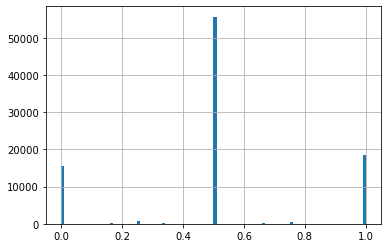

In [960]:
user_feature_df['price_level'].hist(bins=100)

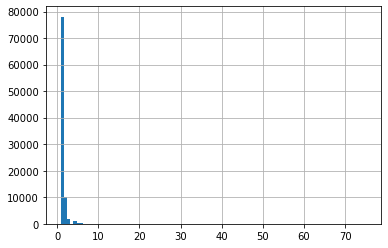

In [961]:
user_feature_df['order_id'].hist(bins=100)

In [962]:
user_feature_df['order_id'].value_counts()

1     78041
2     10234
3      1877
4       873
5       293
6       267
7        71
8        38
12       22
9        19
11       18
10       18
14        8
13        5
15        5
20        4
24        4
21        3
16        2
19        1
18        1
75        1
22        1
35        1
26        1
38        1
Name: order_id, dtype: int64

In [963]:
# 구매 활동성을 3-level로 구분
user_feature_df['order_id'] = user_feature_df['order_id'].apply(lambda x: 3 if x >= 3 else x)
user_feature_df['price_level'] = user_feature_df['price_level'] / 3

In [964]:
user_feature_df['order_id'].value_counts()

1    78041
2    10234
3     3534
Name: order_id, dtype: int64

In [965]:
# log normalization 후, 0~1 사이의 값으로 다시 normalize
user_feature_df['payment_value'] = np.log(user_feature_df['payment_value'])
user_feature_df['payment_value'] = (user_feature_df['payment_value'] - user_feature_df['payment_value'].min()) / (user_feature_df['payment_value'].max() - user_feature_df['payment_value'].min())

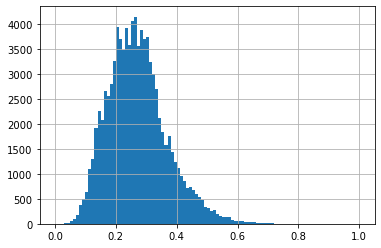

In [966]:
user_feature_df['payment_value'].hist(bins=100)

In [967]:
user_feature_df.head()

,order_id,price_level,payment_value,product_category_name_english
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table]
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty]
0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery]
0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony]
0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony]


In [968]:
# user_feature_df.columns = user_feature_df.columns.to_flat_index()
user_feature_df.columns = ['order_count', 'prefer_price_level', 'total_payment', 'product_category_name_english']

In [969]:
user_feature_df.head()

,order_count,prefer_price_level,total_payment,product_category_name_english
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table]
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty]
0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery]
0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony]
0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony]


----
#### *categorical feature engineering*

In [970]:
from collections import Counter

data = [(1,1,2), (3,3,2,5)]
pd.DataFrame([Counter(x) for x in data]).fillna(0)

,1,2,3,5
0,2.0,1,0.0,0.0
1,0.0,1,2.0,1.0


In [971]:
Counter((1,1,2))

Counter({1: 2, 2: 1})

In [972]:
counts = Counter(['watches_gifts', 'watches_gifts', 'watches'])
for item, count in counts.items():
    print(item, count)
    counts[item] /= sum(counts.values())

watches_gifts 2
watches 1


In [973]:
def get_counter_objs(x):
    counts = Counter(x)
    for item, count in counts.items():
        counts[item] /= sum(counts.values())
    return counts

user_feature_df['category_counter_obj'] = user_feature_df['product_category_name_english'].apply(lambda x: get_counter_objs(x))

In [974]:
user_feature_df.head()

,order_count,prefer_price_level,total_payment,product_category_name_english,category_counter_obj
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table],{'bed_bath_table': 1.0}
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty],{'health_beauty': 1.0}
0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery],{'stationery': 1.0}
0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony],{'telephony': 1.0}
0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony],{'telephony': 1.0}


In [975]:
user_feature_df = user_feature_df.reset_index(inplace=False)

In [976]:
user_feature_df.head()

,customer_unique_id,order_count,prefer_price_level,total_payment,product_category_name_english,category_counter_obj
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0.333333,0.288441,[bed_bath_table],{'bed_bath_table': 1.0}
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0.000000,0.111562,[health_beauty],{'health_beauty': 1.0}
2,0000f46a3911fa3c0805444483337064,1,0.166667,0.235106,[stationery],{'stationery': 1.0}
3,0000f6ccb0745a6a4b88665a16c9f078,1,0.166667,0.162162,[telephony],{'telephony': 1.0}
4,0004aac84e0df4da2b147fca70cf8255,1,0.333333,0.323503,[telephony],{'telephony': 1.0}


In [977]:
data = user_feature_df['category_counter_obj'].tolist()
category_counter_df = pd.DataFrame(data).fillna(0)

In [978]:
category_counter_df.head()

,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,luggage_accessories,computers_accessories,fashion_underwear_beach,...,cds_dvds_musicals,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [979]:
user_feature_df.shape

(91809, 6)

In [980]:
category_counter_df.shape

(91809, 71)

In [985]:
kmeans_df = pd.concat([user_feature_df[['order_count', 'prefer_price_level', 'total_payment']], category_counter_df], axis=1)

In [987]:
kmeans_df.shape

(91809, 74)

In [986]:
kmeans_df.head()

,order_count,prefer_price_level,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,...,cds_dvds_musicals,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine
0,1,0.333333,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000000,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.166667,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.166667,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.333333,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


----
### [다양한 관점으로 K-means 군집 분석 수행]

k: 1 | cost: 1842.5770482735202
k: 2 | cost: 880.0870748189043
k: 3 | cost: 484.4258877281365
k: 4 | cost: 328.13903657403023
k: 5 | cost: 243.14852005274284
k: 6 | cost: 180.2945887285478
k: 7 | cost: 141.36736970272543
k: 8 | cost: 119.77898673818109
k: 9 | cost: 103.25379716184996


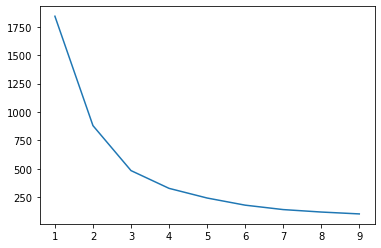

In [988]:
from sklearn.cluster import KMeans

# K-means train & Elbow method
X = kmeans_df[['prefer_price_level', 'total_payment']]

k_list = []
cost_list = []
for k in range (1, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
    
plt.plot(k_list, cost_list)

In [990]:
# selected by elbow method
kmeans = KMeans(n_clusters=4).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
kmeans_df['cluster_num'] = cluster.values
kmeans_df.head()

,order_count,prefer_price_level,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,...,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine,cluster_num
0,1,0.333333,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,0.000000,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1,0.166667,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,0.166667,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,0.333333,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [991]:
print(kmeans_df['cluster_num'].value_counts())

1    47338
3    19212
2    14645
0    10614
Name: cluster_num, dtype: int64


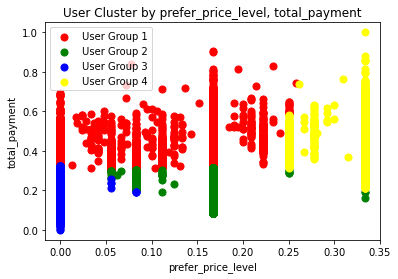

In [993]:
# Visualization
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 0]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 0]['total_payment'], 
            s = 50, c = 'red', label = 'User Group 1')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 1]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 1]['total_payment'], 
            s = 50, c = 'green', label = 'User Group 2')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 2]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 2]['total_payment'], 
            s = 50, c = 'blue', label = 'User Group 3')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 3]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 3]['total_payment'], 
            s = 50, c = 'yellow', label = 'User Group 4')
plt.title('User Cluster by prefer_price_level, total_payment')
plt.xlabel('prefer_price_level')
plt.ylabel('total_payment')
plt.legend()
plt.show()

In [1004]:
# selected by elbow method
kmeans = KMeans(n_clusters=6).fit(X)
cluster_num = kmeans.predict(X)
cluster = pd.Series(cluster_num)
kmeans_df['cluster_num'] = cluster.values
kmeans_df.head()

,order_count,prefer_price_level,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,...,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine,cluster_num
0,1,0.333333,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.000000,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,1,0.166667,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,0.166667,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,1,0.333333,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1005]:
print(kmeans_df['cluster_num'].value_counts())

0    36319
3    31152
4    10570
5     5185
1     5049
2     3534
Name: cluster_num, dtype: int64


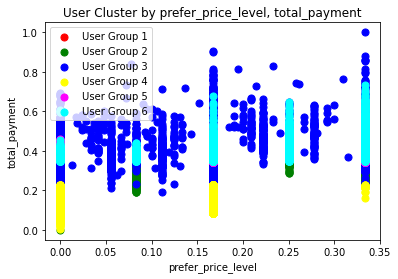

In [1006]:
# Visualization
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 0]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 0]['total_payment'], 
            s = 50, c = 'red', label = 'User Group 1')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 1]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 1]['total_payment'], 
            s = 50, c = 'green', label = 'User Group 2')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 2]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 2]['total_payment'], 
            s = 50, c = 'blue', label = 'User Group 3')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 3]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 3]['total_payment'], 
            s = 50, c = 'yellow', label = 'User Group 4')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 4]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 4]['total_payment'], 
            s = 50, c = 'magenta', label = 'User Group 5')
plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 5]['prefer_price_level'], 
            kmeans_df[kmeans_df['cluster_num'] == 5]['total_payment'], 
            s = 50, c = 'cyan', label = 'User Group 6')
# plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 6]['prefer_price_level'], 
#             kmeans_df[kmeans_df['cluster_num'] == 6]['total_payment'], 
#             s = 50, c = 'black', label = 'User Group 7')
# plt.scatter(kmeans_df[kmeans_df['cluster_num'] == 7]['prefer_price_level'], 
#             kmeans_df[kmeans_df['cluster_num'] == 7]['total_payment'], 
#             s = 50, c = 'orange', label = 'User Group 8')
plt.title('User Cluster by prefer_price_level, total_payment')
plt.xlabel('prefer_price_level')
plt.ylabel('total_payment')
plt.legend()
plt.show()

----
### [t-sne 차원 축소 시각화]

In [1009]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=300)
transformed = model.fit_transform(kmeans_df[])

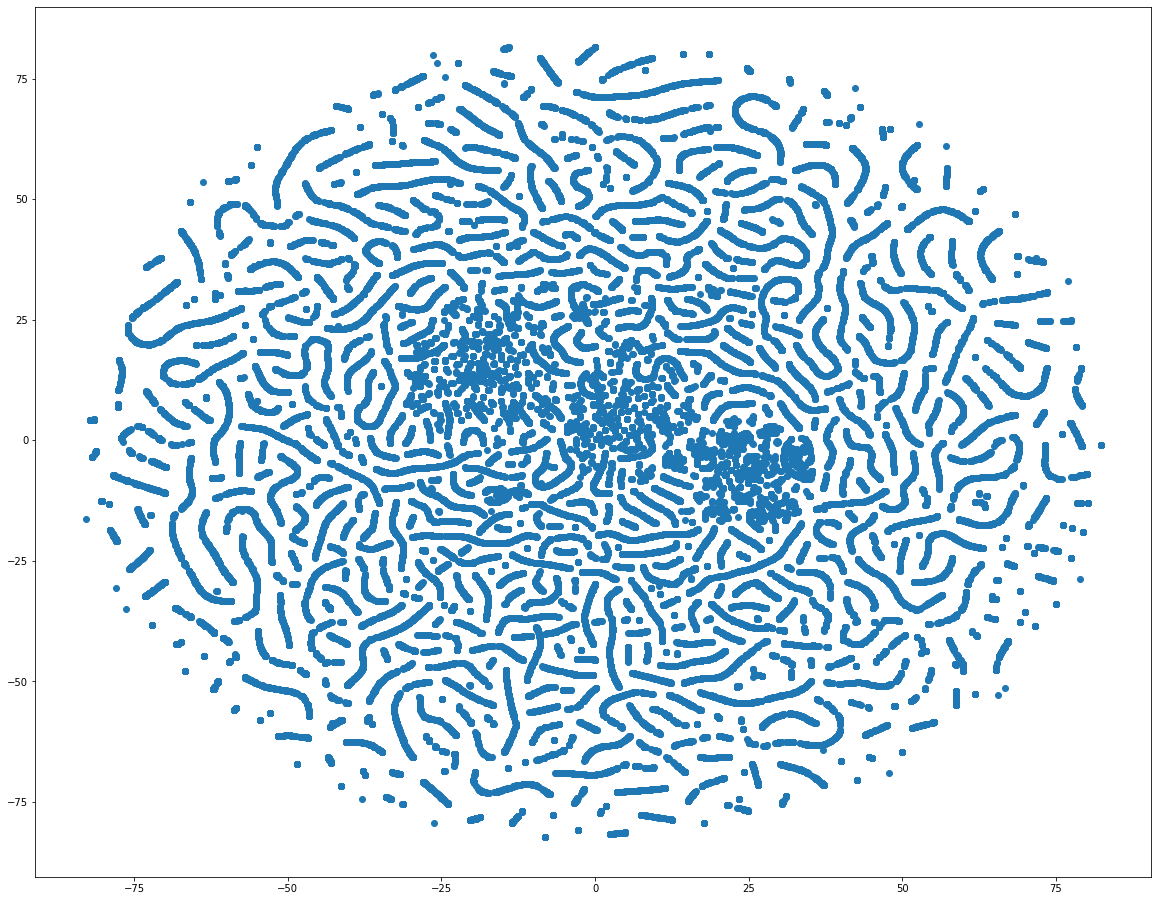

In [1010]:
plt.rcParams['figure.figsize'] = [20, 16]
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

In [1014]:
kmeans_df[kmeans_df.columns[~kmeans_df.columns.isin(['order_count','prefer_price_level'])]]

,total_payment,bed_bath_table,health_beauty,stationery,telephony,garden_tools,sports_leisure,fashion_bags_accessories,luggage_accessories,computers_accessories,...,fashio_female_clothing,party_supplies,small_appliances_home_oven_and_coffee,music,diapers_and_hygiene,arts_and_craftmanship,security_and_services,fashion_childrens_clothes,la_cuisine,cluster_num
0,0.288441,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.111562,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,0.235106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.162162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.323503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91804,0.649430,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
91805,0.233050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
91806,0.263549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
91807,0.282061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1015]:
model = TSNE(learning_rate=300)
transformed = model.fit_transform(kmeans_df[kmeans_df.columns[~kmeans_df.columns.isin(['order_count','prefer_price_level'])]])

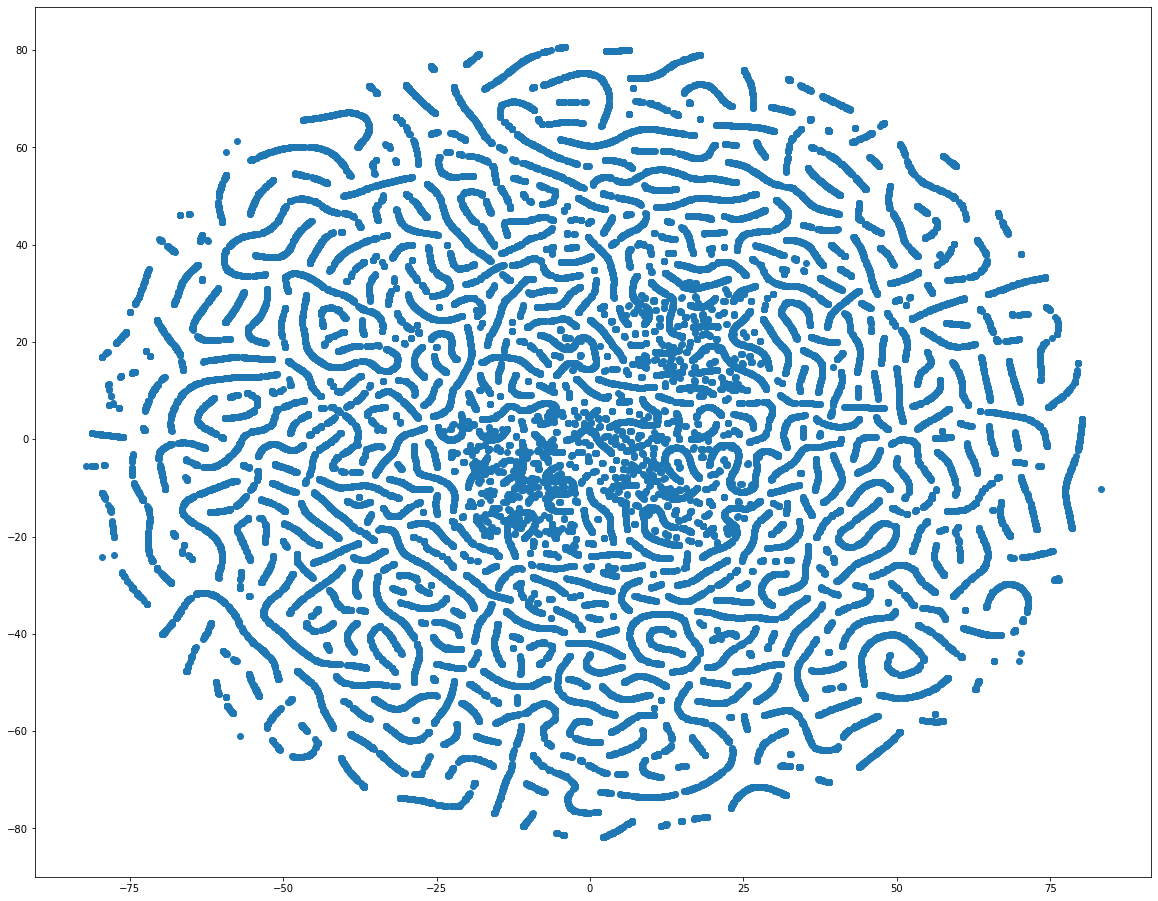

In [1016]:
plt.rcParams['figure.figsize'] = [20, 16]
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys)
plt.show()

----
# 5. 심화 예제
### [유저 행동 기반 장바구니 분석]

----
#### *Association Rule*

In [1020]:
from apyori import apriori

# 장바구니 형태의 데이터(트랜잭션 데이터)를 생성합니다.
transactions = [
    ['손흥민', '시소코'],
    ['손흥민', '케인'],
    ['손흥민', '케인', '포체티노']
]

# 연관 분석을 수행합니다.
results = list(apriori(transactions))
for result in results:
    print(result)

RelationRecord(items=frozenset({'손흥민'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)])
RelationRecord(items=frozenset({'시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'시소코'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0)])
RelationRecord(items=frozenset({'포체티노'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'포체티노'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'손흥민', '시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민', '시소코'}), confidence=0.3333333333333333, lift=1.0), Or

In [1021]:
# 지지도 0.5, 신뢰도 0.6, 향상도 1.0 이상이면서 (손흥민, 케인) 처럼 규칙의 크기가 2 이하인 규칙을 추출합니다.
list(apriori(transactions,
             min_support=0.5,
             min_confidence=0.6,
             min_lift=1.0,
             max_length=2))

[RelationRecord(items=frozenset({'손흥민'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)]),
 RelationRecord(items=frozenset({'케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0)]),
 RelationRecord(items=frozenset({'손흥민', '케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민', '케인'}), confidence=0.6666666666666666, lift=1.0), OrderedStatistic(items_base=frozenset({'손흥민'}), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0), OrderedStatistic(items_base=frozenset({'케인'}), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)])]

In [1067]:
user_transactions = order_df.groupby('customer_unique_id')['product_category_name_english'].unique().reset_index()

In [1068]:
user_transactions.head()

,customer_unique_id,product_category_name_english
0,0000366f3b9a7992bf8c76cfdf3221e2,[bed_bath_table]
1,0000b849f77a49e4a4ce2b2a4ca5be3f,[health_beauty]
2,0000f46a3911fa3c0805444483337064,[stationery]
3,0000f6ccb0745a6a4b88665a16c9f078,[telephony]
4,0004aac84e0df4da2b147fca70cf8255,[telephony]


In [1069]:
user_transactions[user_transactions['product_category_name_english'].map(len) > 1]

,customer_unique_id,product_category_name_english
22,000fbf0473c10fc1ab6f8d2d286ce20c,"[musical_instruments, toys]"
35,001926cef41060fae572e2e7b30bd2a4,"[electronics, computers_accessories]"
36,001928b561575b2821c92254a2327d06,"[furniture_living_room, bed_bath_table]"
103,004288347e5e88a27ded2bb23747066c,"[luggage_accessories, cool_stuff]"
224,0097fca0db567f5ca79509b7b4fc1c2d,"[flowers, furniture_decor]"
...,...,...
91380,fed2005ccab4fcf1a40ebdaff032a148,"[computers_accessories, telephony]"
91384,fed519569d16e690df6f89cb99d4e682,"[toys, bed_bath_table]"
91583,ff5f29fbfd0a13f7e7ed9f7b92a32194,"[bed_bath_table, home_confort]"
91644,ff8892f7c26aa0446da53d01b18df463,"[bed_bath_table, watches_gifts]"


In [1070]:
user_transactions = user_transactions[user_transactions['product_category_name_english'].map(len) > 1]

In [1071]:
user_transactions['product_category_name_english'].tolist()[:10]

[array(['musical_instruments', 'toys'], dtype=object),
 array(['electronics', 'computers_accessories'], dtype=object),
 array(['furniture_living_room', 'bed_bath_table'], dtype=object),
 array(['luggage_accessories', 'cool_stuff'], dtype=object),
 array(['flowers', 'furniture_decor'], dtype=object),
 array(['furniture_decor', 'baby'], dtype=object),
 array(['home_appliances', 'bed_bath_table'], dtype=object),
 array(['bed_bath_table', 'housewares'], dtype=object),
 array(['garden_tools', 'auto'], dtype=object),
 array(['toys', 'musical_instruments'], dtype=object)]

In [1072]:
user_transactions['product_category_name_english'] = user_transactions['product_category_name_english'].apply(lambda x: x.tolist())

In [1073]:
user_transactions['product_category_name_english'].tolist()[:10]

[['musical_instruments', 'toys'],
 ['electronics', 'computers_accessories'],
 ['furniture_living_room', 'bed_bath_table'],
 ['luggage_accessories', 'cool_stuff'],
 ['flowers', 'furniture_decor'],
 ['furniture_decor', 'baby'],
 ['home_appliances', 'bed_bath_table'],
 ['bed_bath_table', 'housewares'],
 ['garden_tools', 'auto'],
 ['toys', 'musical_instruments']]

In [1074]:
transactions = user_transactions['product_category_name_english'].tolist()

In [1075]:
results = list(apriori(transactions,
                       min_support=0.001,
                       min_confidence=0.01,
                       min_lift=1.0,
                       max_length=2))

In [1076]:
results[:3]

[RelationRecord(items=frozenset({'auto'}), support=0.056638811513463325, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'auto'}), confidence=0.056638811513463325, lift=1.0)]),
 RelationRecord(items=frozenset({'baby'}), support=0.07845868152274837, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'baby'}), confidence=0.07845868152274837, lift=1.0)]),
 RelationRecord(items=frozenset({'bed_bath_table'}), support=0.24419684308263695, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'bed_bath_table'}), confidence=0.24419684308263695, lift=1.0)])]

In [1077]:
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        print(items[0], "||", items[1], result.support)

air_conditioning || sports_leisure 0.001392757660167131
furniture_decor || art 0.002785515320334262
audio || watches_gifts 0.003714020427112349
auto || consoles_games 0.001392757660167131
construction_tools_construction || auto 0.001392757660167131
auto || electronics 0.002321262766945218
auto || pet_shop 0.0018570102135561746
auto || telephony 0.004178272980501393
baby || bed_bath_table 0.017177344475394613
baby || cool_stuff 0.014391829155060354
fashion_shoes || baby 0.001392757660167131
toys || baby 0.012534818941504178
bed_bath_table || cool_stuff 0.010677808727948004
fashion_underwear_beach || bed_bath_table 0.001392757660167131
furniture_decor || bed_bath_table 0.07056638811513463
health_beauty || bed_bath_table 0.012999071494893221
home_confort || bed_bath_table 0.025069637883008356
housewares || bed_bath_table 0.02924791086350975
kitchen_dining_laundry_garden_furniture || bed_bath_table 0.002785515320334262
computers_accessories || electronics 0.00510677808727948
computers_acce